In [18]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy.stats
import statsmodels.api as sm
import statsmodels.tsa as tsa
import numpy as np
from sklearn import preprocessing

In [2]:
def read_pickle(path):
    
    input_file = open(path,'rb')
    variable = pickle.load(input_file)
    input_file.close()
    return(variable)

In [3]:
# Read in data
data = read_pickle('../data/watch/processed_data/train_df.pkl')

In [4]:
data.columns

Index(['subject_id', 'activity_class', 'timestamp', 'accel_x', 'accel_y',
       'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'is_exercise', 'time_period'],
      dtype='object')

## Time-Series EDA

In [22]:
def multi_scatter_plot(data, x_variables, y_variable, subject_id):
    ''' For a specific subject, plot their xyz scatterplots, colour coded
        for exercise/non-exercise label'''
    
    for i in x_variables:
        sns.lmplot(x='time_period', y=i, data=data[data['subject_id']==subject_id],
                   fit_reg=False, hue=y_variable, legend=False, height=4, aspect=2.5)
        
    return None

def pacf_plots(data, x_variables, y_variable, subject_id, downsample_steps=10):
    ''' For a specific subject, plot their xyz pacf'''
    
    df = data.copy(deep=True)
    
    # Downsample
    df = df[df['subject_id'] == subject_id]
    df['downsample'] = df['time_period'] % downsample_steps
    df = df[df['downsample'] == 0]
    
    # Plot pacfs for each variables
    for i in x_variables:
        series = sm.graphics.tsa.plot_pacf(df[i], zero = False)
    
    return None

def boxplot_plots(data, x_variables, y_variable, subject_id, figsize = (20, 35)):
    ''' For a specific subject, plot their xyz histograms'''
    
    df = data.copy(deep = True)
    df = df[df['subject_id'] == subject_id]
    rows = len(x_variables)
    fig, axs = plt.subplots(nrows = rows, ncols=1, figsize = figsize)
    plt.subplots_adjust(hspace = 0.2)
    counter = 0
    
    for i in x_variables:
        sns.boxplot(y = df[i], x = df[y_variable], ax=axs[counter]) # boxplot, switch axis
        counter += 1
        
    return None


def basic_time_series_transformations(data, x_variables, y_variable, boxcox=True, 
                                      differencing=True, standardization=True):
    ''' For each time-dependent variable, perform the basic box-cox and first difference transformation'''
    
    df = data.copy(deep=True)
    df = df.set_index(['subject_id', 'timestamp', 'activity_class', 'is_exercise', 'time_period'])
    keep_index = df.index # Instead of a messy merge, we can use this method to add the index and target back
    df = df.reset_index()
    df = df[x_variables] # Only take features
    standard_scaler = preprocessing.StandardScaler()
    transformed_x_variables = len(x_variables) * [None]
    counter = 0
    
    # Perform transformations
    for i in x_variables:
        
        # Box-Cox estimation
        #pdb.set_trace()
        df[i] = df[i] - min(df[i]) + 0.0001
        y, fitted_lambda = scipy.stats.boxcox(df[i],lmbda = None)
        
        # First difference, make first element nan, loss from differencing
        y = np.append([np.nan], np.diff(y, n=1))
        df[i] = y
        
        # Create new column names
        transformed_x_variables[counter] = i + '_transformed'
        counter += 1
        
        print(i, ' completed')
        
    # Standardize data
    df = standard_scaler.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = transformed_x_variables
    
    # Recreate index
    df.index = keep_index
    df = df.reset_index()
    
    return(df)

def add_initial_features(data, x_variables, window):
    ''' Engineer some initial features we can explore to guide modelling'''
    
    df = data.copy(deep = True)
    
    # Create volatility measures
    for i in x_variables:
        df[i + '_vol'] = df[i].rolling(window).std()
    
    return(df)

def augmented_ad_fuller(data, x_variables, subject_id):
    ''' Perform augmented AD Fuller test for list of variables. The null is a unit root is present.
        Lower p-value/more negative AD Fuller statistic is, the more confident we are
        of rejecting the null'''
    
    df = data.copy(deep = True)
    df = df[df['subject_id'] == subject_id]
    
    # Loop through and print AD Fuller output
    for i in x_variables:
        adfuller = tsa.stattools.adfuller(df[i])
        print('Variable ', i, ' ADF Statistic: ',  adfuller[0], ' | p-value ', adfuller[1])
        
    return None
        

In [6]:
subject_ids = list(set(data['subject_id']))
random.shuffle(subject_ids)
subject_ids[0]

1621

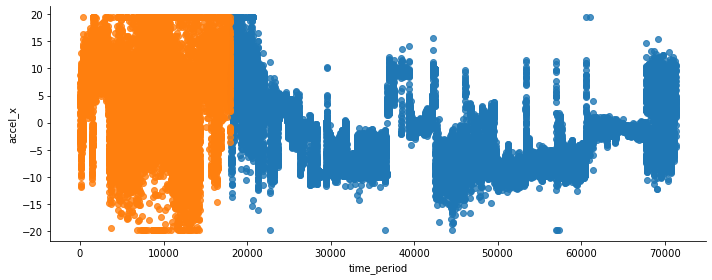

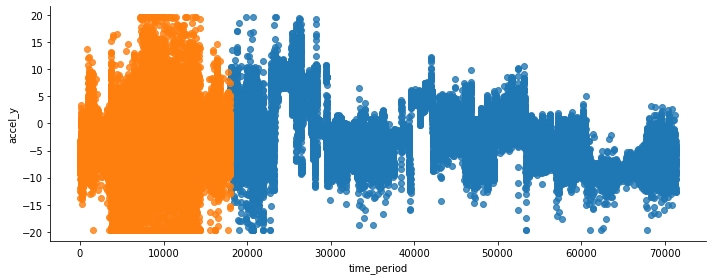

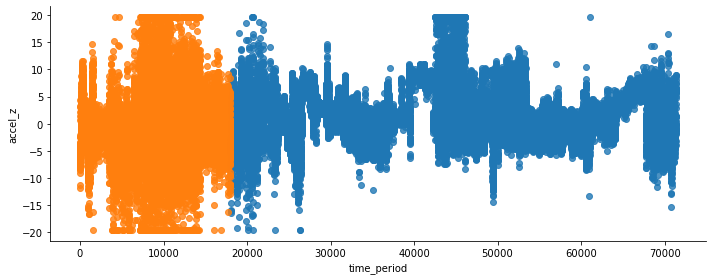

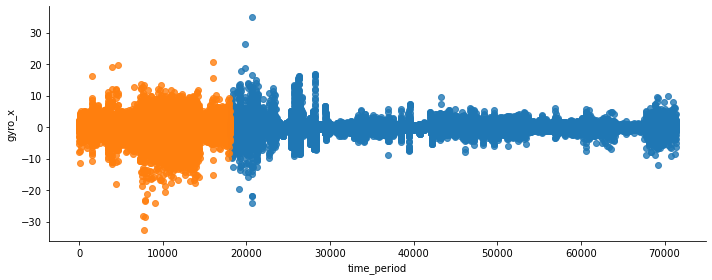

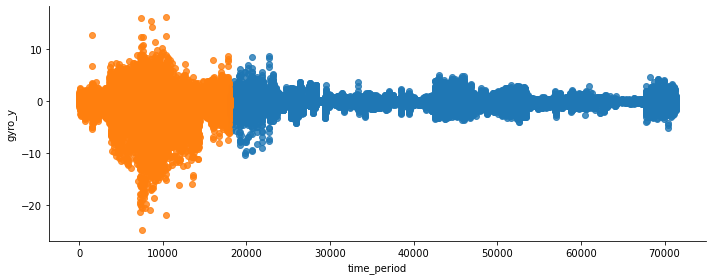

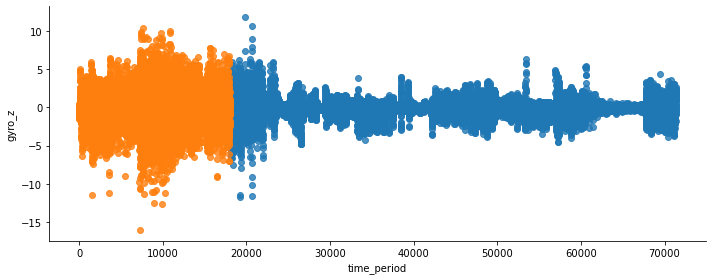

In [7]:
# Notes:
# It takes too much real estate to plot all the subjects. But flipping through them with the random shuffle above,
# there appears to be some patterns. The accelerometer measures high values maxing at 20 and minning at -20 
# during exercise periods, and may be reflected in some sort of variance/volatility measure.
# The gyro does the same but not as consistently throughout the exercise period-- this may be reflective of
# different activities, e.g. running vs kicking. 

# We may be able to mix time-series & machine learning techniques here. E.g. columns for +10, +20, +30 etc.
# time period forecast as features. Self-exciting threshold auto-regressive models, GARCH or similar could be useful.
# But we need to also think about speed. Fitting a time series for each training data point is a lot of iterations.

# Alternative is to use these time-series models as inspiration, but approach it from a curve fitting perspective,
# no autoregressive or moving average component.
x_variables = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
multi_scatter_plot(data, x_variables=x_variables, y_variable='is_exercise', subject_id=subject_ids[0])

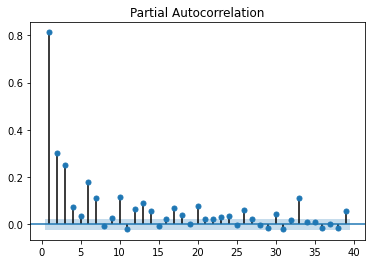

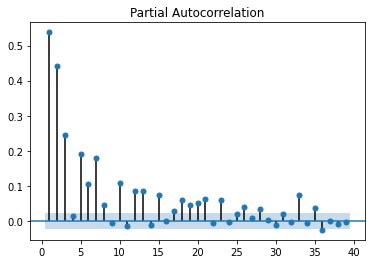

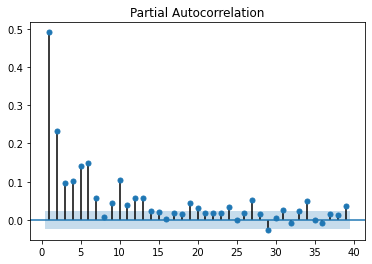

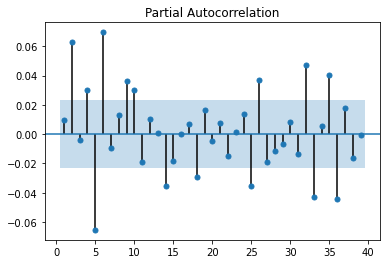

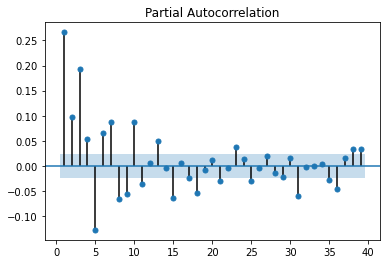

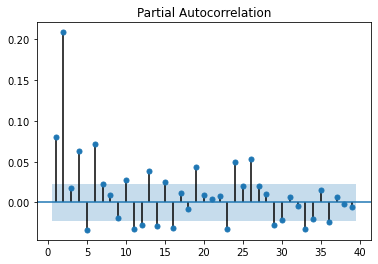

In [8]:
# Pretty expected, but we're seeing very significant partial autocorrelations.

# Reminder: PACF works by fitting a regression of xt-k values. Then it outputs xt_hat and xt-k_hat. Subract
# xt and xt-k by their fitted values, then output their covariance. The idea is to explain away any
# internal autocorrelation that is being picked up, e.g. xt and xt-k may appear correlated simply because they
# are both correlated to xt-k-n.

x_variables = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
pacf_plots(data, x_variables=x_variables, y_variable='is_exercise', 
           subject_id=subject_ids[0], downsample_steps=10)

In [9]:
x_variables = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
data2 = basic_time_series_transformations(data, x_variables=x_variables, y_variable='is_exercise', 
                                          boxcox=True, differencing=True)

accel_x  completed
accel_y  completed
accel_z  completed
gyro_x  completed
gyro_y  completed
gyro_z  completed


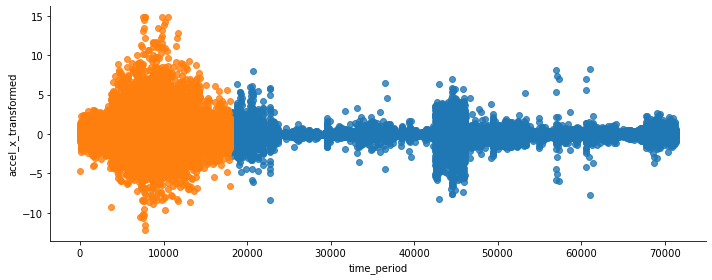

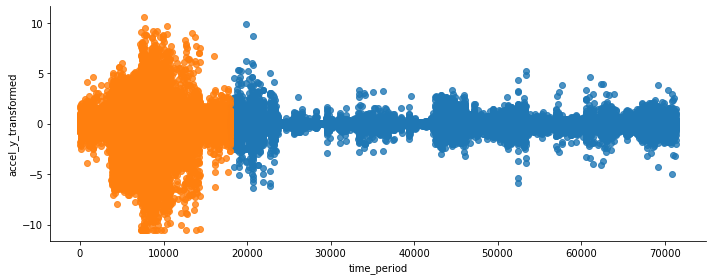

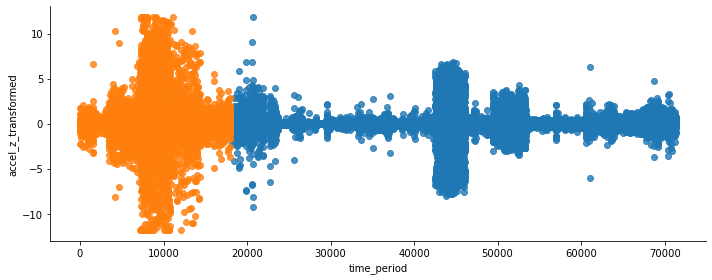

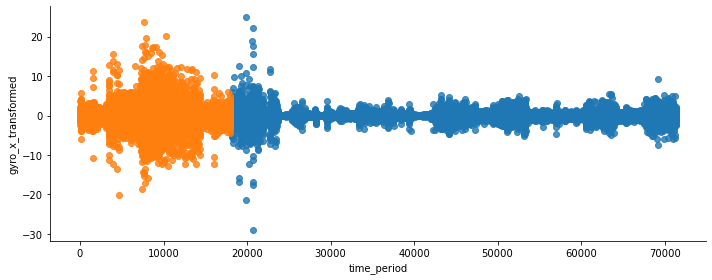

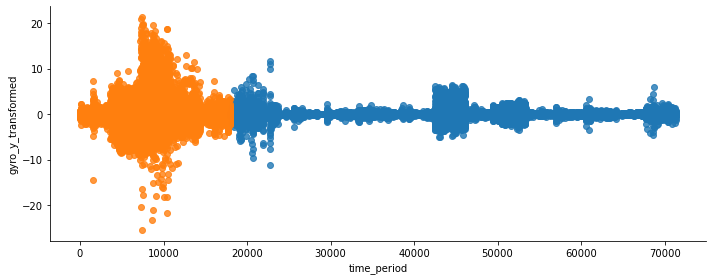

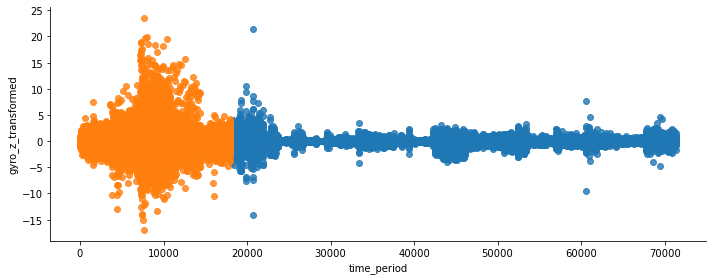

In [10]:
x_variables = ['accel_x_transformed', 'accel_y_transformed', 'accel_z_transformed', 
               'gyro_x_transformed', 'gyro_y_transformed', 'gyro_z_transformed']
multi_scatter_plot(data2, x_variables=x_variables, y_variable='is_exercise', subject_id=subject_ids[0])

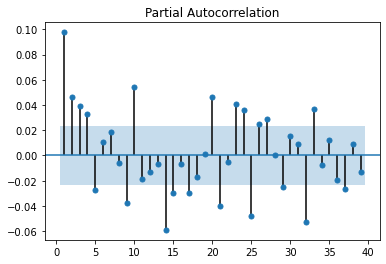

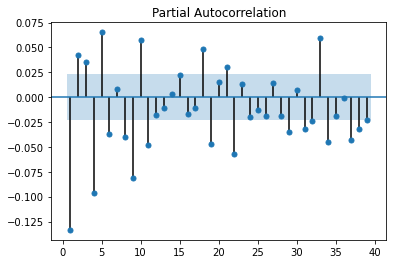

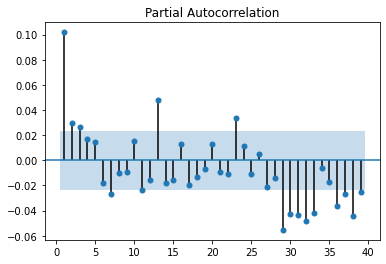

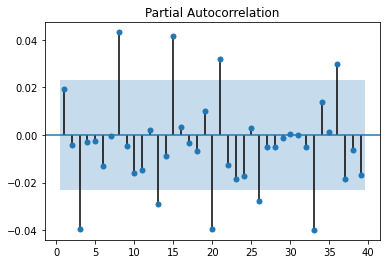

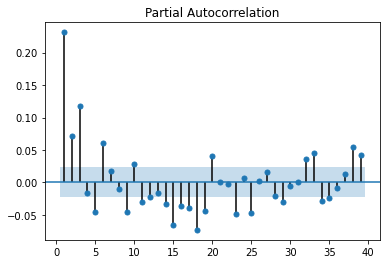

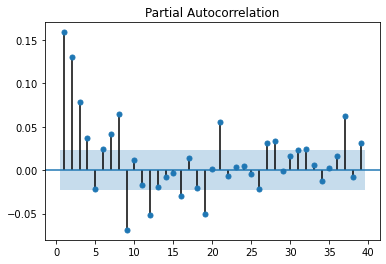

In [11]:
# Still seeing some partial autocorrelations, but for accelerometer data, we know longer see the slow decay
# that implies a need for differencing. 

x_variables = ['accel_x_transformed', 'accel_y_transformed', 'accel_z_transformed', 
               'gyro_x_transformed', 'gyro_y_transformed', 'gyro_z_transformed']
pacf_plots(data2, x_variables=x_variables, y_variable='is_exercise', 
           subject_id=subject_ids[0], downsample_steps=10)

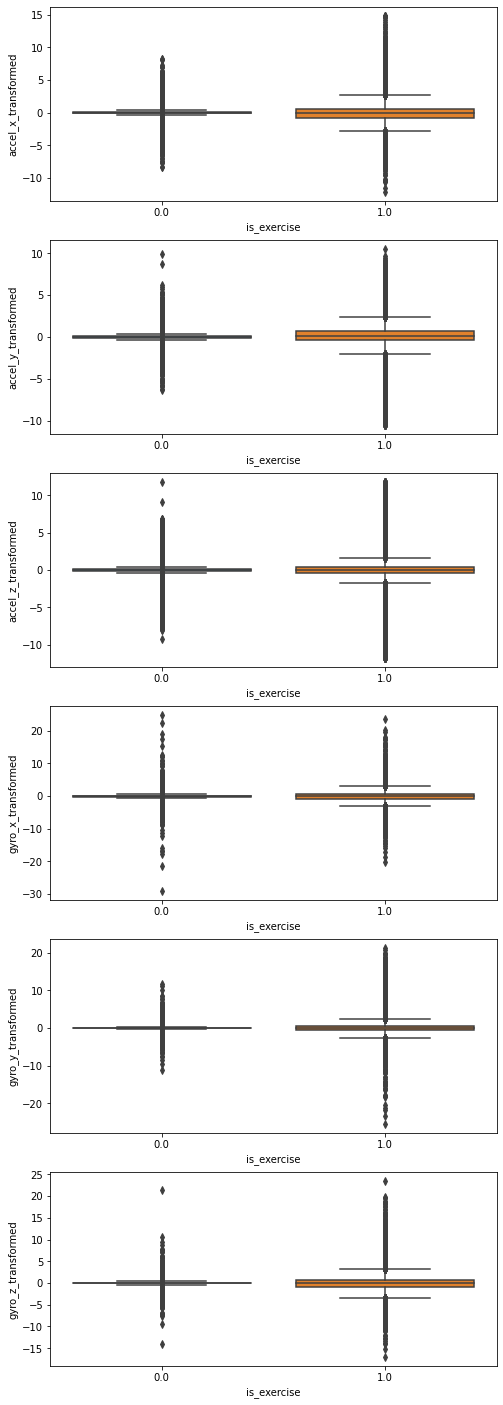

In [12]:
# Weird to look at but essentially, after all the transformations, most of the signal is 
# centered around or near zero. 

# We don't really see a significant shift between the two classes but we do see what seems like
# a difference in spread. Like our initial hypothesis, we can look to target volatility.

x_variables = ['accel_x_transformed', 'accel_y_transformed', 'accel_z_transformed', 
               'gyro_x_transformed', 'gyro_y_transformed', 'gyro_z_transformed']
boxplot_plots(data2, x_variables=x_variables, y_variable='is_exercise', 
              subject_id=subject_ids[0], figsize = (8, 25))

In [15]:
x_variables = ['accel_x_transformed', 'accel_y_transformed', 'accel_z_transformed', 
               'gyro_x_transformed', 'gyro_y_transformed', 'gyro_z_transformed']
data2 = add_initial_features(data2, x_variables, window=50)

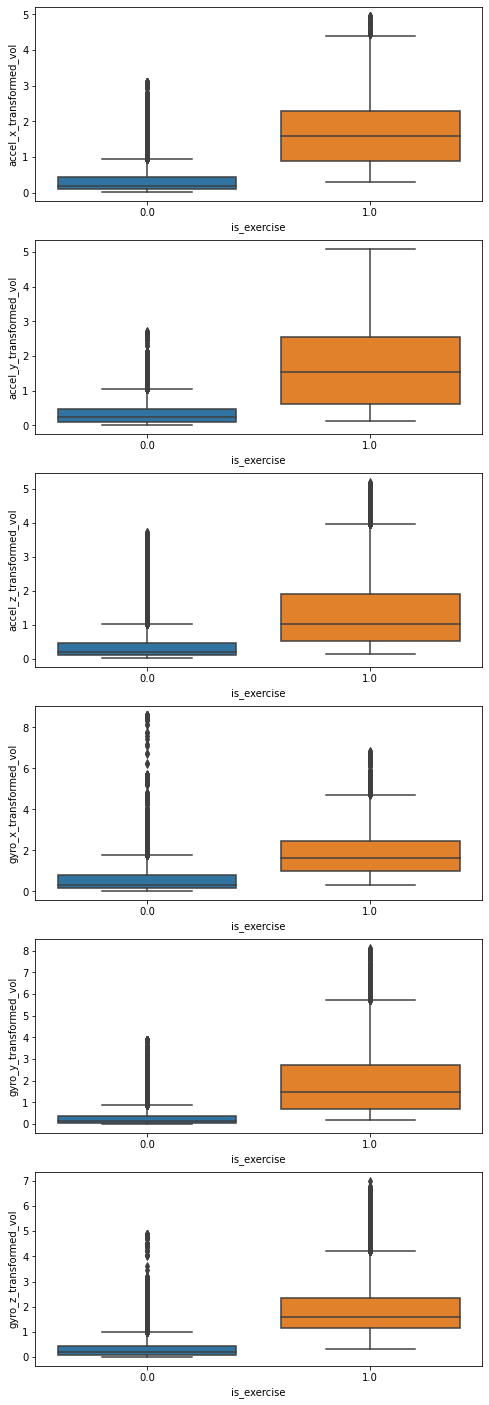

In [16]:
# Awesome, we get clean separation with volatility
x_variables = ['accel_x_transformed_vol', 'accel_y_transformed_vol', 'accel_z_transformed_vol', 
               'gyro_x_transformed_vol', 'gyro_y_transformed_vol', 'gyro_z_transformed_vol']
boxplot_plots(data2, x_variables=x_variables, y_variable='is_exercise', 
              subject_id=subject_ids[0], figsize = (8, 25))

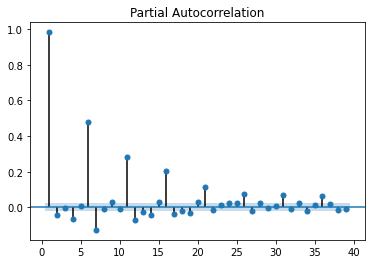

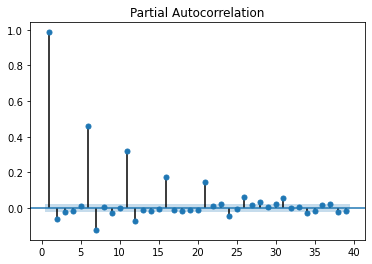

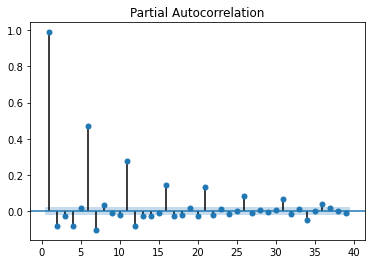

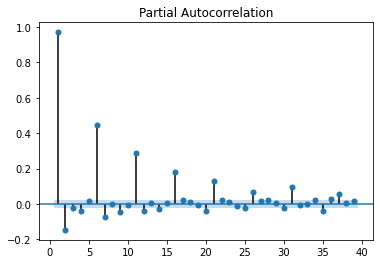

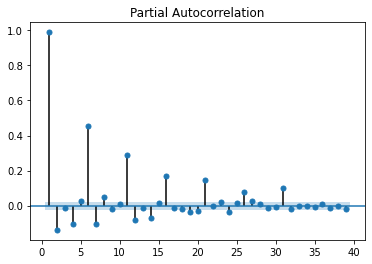

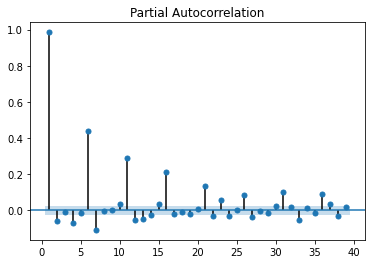

In [17]:
# Still seeing some slow decay, we might need an ARMA/ARIMA model to account for autocorrelation.
x_variables = ['accel_x_transformed_vol', 'accel_y_transformed_vol', 'accel_z_transformed_vol', 
               'gyro_x_transformed_vol', 'gyro_y_transformed_vol', 'gyro_z_transformed_vol']
pacf_plots(data2, x_variables=x_variables, y_variable='is_exercise', 
           subject_id=subject_ids[0], downsample_steps=10)